In [28]:
from matplotlib import projections
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
def generate_lorenz(dt,T,x0):
    
    x = np.zeros((3,T))
    x[:,0] = x0
    for t in range(T-1):
        x[0,t+1] = x[0,t] + dt*sigma*(x[1,t] - x[0,t])
        x[1,t+1] = x[1,t] + dt*(x[0,t]*(r - x[2,t]) - x[1,t])
        x[2,t+1] = x[2,t] + dt*(x[0,t]*x[1,t] - b*x[2,t])
    return x

In [8]:
def train_rnn(x: np.array([]),n_neurons: int, k_ridge: float, sigma: float):
    #Using linear regression (Least square) as training
    n_inputs = np.size(x,axis=0)
    t_train = np.size(x,axis=1)
    w_in = np.random.normal(0,np.sqrt(1/n_neurons),(n_neurons, n_inputs))
    w_r = np.random.normal(0,np.sqrt(sigma),(n_neurons, n_neurons))
    r = np.zeros((n_neurons,t_train))
    r0 = np.zeros((n_neurons,1))
    
    for t in range(t_train):
        arg1 = np.matmul(w_r,np.transpose(np.matrix(r[:,t])))
        arg2 = np.matmul(w_in,np.transpose(np.matrix(x[:,t])))
        if t == t_train-1:
            r0 = np.reshape(np.tanh(arg1 + arg2),-1)
        else:
            r[:,t+1] = np.reshape(np.tanh(arg1 + arg2),-1)
    matrix1 = np.matmul(x,np.transpose(r))
    matrix2 = np.linalg.inv(np.matmul(r,np.transpose(r)) + k_ridge*np.identity(n_neurons))
    w_out = np.matmul(matrix1,matrix2)
    return w_out, w_in, w_r, r0


def rnn_predict(w_out: np.array([]), w_in: np.array([]), w_r: np.array([]), t_predict: int, r0: np.array([])):
    n_inputs = np.size(w_in,axis=1)
    x_pred = np.zeros((n_inputs,t_predict))
    r = np.zeros((n_neurons,t_predict+1))
    r[:,0] = r0
    for t in range(t_predict):
        x_pred[:,t] = np.matmul(w_out,r[:,t])
        arg1 = np.matmul(w_r,np.transpose(np.matrix(r[:,t])))
        arg2 = np.matmul(w_in,np.transpose(np.matrix(x_pred[:,t])))
        r[:,t+1] = np.reshape(np.tanh(arg1 + arg2),-1)
    return x_pred

In [2]:
from tqdm import trange

def sv_n_error(isOneD):
    
    sigma = [10**i/10**(n_samples-sample_drift) for i in range(n_samples)]
    mse = np.zeros((n_samples,1))
    sing_val = np.zeros((n_samples,1))
    y = np.matrix(x_train[1,:])
    y_test = np.asarray(x_test[1,:])

    for i in trange(n_samples):
        for j in range(monka):
            if isOneD:
                w_out, w_in, w_r, r0 = train_rnn(y, n_neurons, k_ridge, sigma[i])
            else:
                w_out, w_in, w_r, r0 = train_rnn(x_train, n_neurons, k_ridge, sigma[i])
            x_pred = rnn_predict(w_out, w_in, w_r, t_predict, r0)
            u, s, vh = np.linalg.svd(w_r)
            
            if isOneD:
                x_pred = np.reshape(x_pred,-1)
                mse[i] += MSE(y_test,x_pred)/monka
            else:
                mse[i] += MSE(np.transpose(x_test),np.transpose(x_pred))/monka
            sing_val[i] += max(s)/monka
    return sing_val, mse

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [04:33<00:00,  9.11s/it]


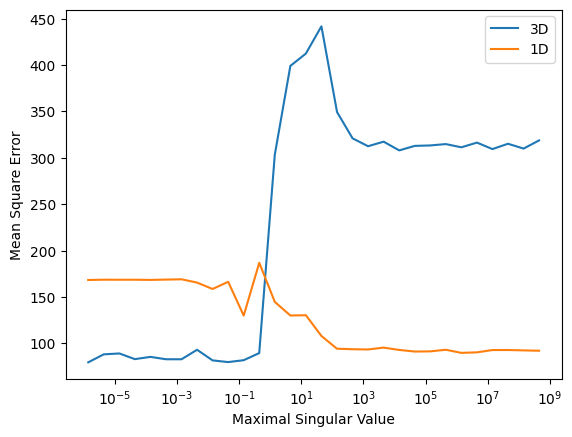

In [31]:
sigma = 10
r = 28
b = 8/3
dt = 0.01
k_ridge = 0.01
n_neurons = 500
n_samples = 30
T = 5000
T_train = int(0.85*T)
t_predict = T - T_train
monka = 10
sample_drift = 15
x0 = np.array([1,1,1])
x = generate_lorenz(dt,T,x0)
x_train = x[:,range(T_train)]
x_test = x[:,range(T_train,T)]

#3
sing_val, mse = sv_n_error(False)
plt.plot(sing_val,mse, label='3D')
sing_val, mse = sv_n_error(True)
plt.plot(sing_val,mse, label='1D')
plt.xscale("log")
plt.xlabel('Maximal Singular Value')
plt.ylabel('Mean Square Error')
plt.legend()
plt.show()

In [5]:
def jacoby(x: np.array([])):
    return np.array([[-sigma, sigma, 0], [r-x[2],-1,-x[0]], [x[1],x[0],-b]])


def get_lupanov(x: np.array([])):
    lambdas = np.zeros((3,1))
    Q = np.identity(3)
    rango = range(500,T)
    for t in rango:
        M = np.identity(3) + jacoby(x[:,t]) * dt
        a = np.matmul(M,Q)
        Q, R = np.linalg.qr(a, mode='complete')
        for i in range(3):
            lambdas[i] += np.log(abs(R[i,i]))/(dt*len(rango))
    return lambdas

In [23]:
sigma = 10
r = 28
b = 8/3
dt = 0.01
k_ridge = 0.01
n_neurons = 500
n_samples = 30
T = 5000
T_train = int(0.85*T)
t_predict = T - T_train
monka = 10
sample_drift = 15
x0 = np.array([1,1,1])
x = generate_lorenz(dt,T,x0)
x_train = x[:,range(T_train)]
x_test = x[:,range(T_train,T)]

Lypanov exponents: [[ 9.16158976e-01]
 [-7.47140748e-03]
 [-1.48369097e+01]]


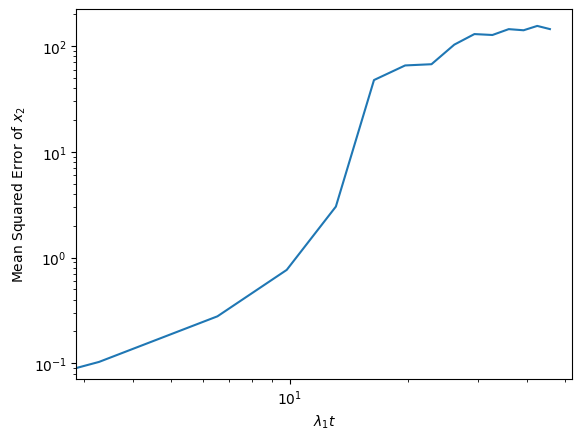

In [29]:
lambdas = get_lupanov(x)
print(f'Lypanov exponents: {lambdas}')
lyp1 = lambdas[0]
y = np.matrix(x_train[1,:])
w_out, w_in, w_r, r0 = train_rnn(y, n_neurons, k_ridge,1/n_neurons)
x_pred_x2 = rnn_predict(w_out, w_in, w_r, t_predict, r0)
y_test = np.asarray(x_test[1,:])
x_pred_x2 = np.reshape(x_pred_x2,-1)
ind_bigus = int(t_predict/50)
mse = np.zeros(ind_bigus)
tot_time = lyp1*T*dt
t_scale = np.linspace(0,tot_time,ind_bigus)
for i in range(1,ind_bigus):
    mse[i] = MSE(y_test[range(i*50)], x_pred_x2[range(i*50)])
plt.figure()
plt.plot(t_scale, mse)
plt.xscale("log")
plt.yscale('log')
plt.xlabel(r'$\lambda_1 t$')
plt.ylabel(r'Mean Squared Error of $x_2$')
plt.show()